# Divided differences using sparse matrix

Import the usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [2]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [3]:
def forward_difference(a, b, N):
  h = (b-a)/N
 
  # Compute FD matrix as sparse using Compressed Sparse Row (CSR) format 
  data=[-np.ones(N+1),np.ones(N)]
  FD=sp.diags(data,[0,1],format="csr")
  return FD/h

In [8]:
a=0 
b=1
N=5
print(forward_difference(a,b,N).todense())


[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [15]:
t = sym.var('t')
my_f = 0.5 * t**2
fsym = sym.lambdify(t, my_f )

a=0 
b=1
N = 100

# Evaluate FD matrix
FD=forward_difference(a,b,N)

# Values of the derivative at the 
# internal grid points
x=np.linspace(0,1,N+1)
ux=FD.dot(fsym(x))[1:N]

# Print results


**Exercise.** Find a way to evaluate execution time and compare full vs sparse exectution time

In [11]:
import time


In [20]:
sparse_time=[]
total_time=[]
for i in range(15):
  N=2**N
  x=np.linspace(0,1,N+1)
  start_time=time.time()
  ux_sparse=FD.dot(fsym(x))[1:N]
  sparse_time[i]=time.time()-start_time
  ux_full=FD.todense().dot(fsym(x))[1:N]
  total_time[i]=time.time()-start_time
  
print("sparse time=",sparse_time)
print("full time=",total_time)

ValueError: ignored

In [21]:
%timeit ux_sparse=FD.dot(fsym(x))[1:N]

The slowest run took 11.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.7 µs per loop


# Central finite differences in 1D

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$, 

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [24]:
def CD2(N):
  # Function defining numerator of
  # second central FD formula on a 
  # uniform grid in sparse CSR format
  data=[np.ones(N),-2*np.ones(N+1),np.ones(N)]
  return sp.diags(data,[-1,0,1],format="csr")

In [26]:
print(CD2(10).todense())

[[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

u(x)=sin(x)

In [27]:
# Define right-hand side function
t = sym.var('t')
my_f = sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F$ 

with $A$ the nominator of CD formula.

In [38]:
# Problem domain
a=0
b=2*np.pi


# Size of grid
N=100
h=(b-a)/N
# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*rhs_f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A=A[1:-1,1:-1]



Import solver

In [39]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

0.00032905176294129035


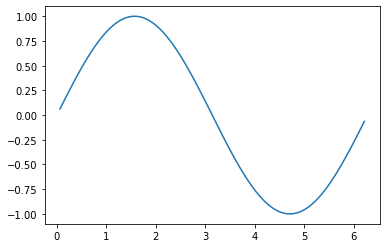

In [40]:
# Compute solution at internal nodes
FD_sol=spsolve(A,F)

#plot solution
plt.plot(x[1:-1],FD_sol)
# print max error
print(np.max(np.abs(FD_sol-exact_sol(x[1:-1]))))


**Exercise 1.** test for convergence and plot convergence plot

**Exercise 2.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

**Exercise 3.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

**Exercise 4.** Solve the reaction-advection-diffusion problem:

$-\alpha u''(x)+\beta u''(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


**Exercise 5.** Now take any of the problems above, but this time with data such that you do not know the exact solution. How would you test the order of convergence of the FD method?

**Exersie 6.** Consider again the problem from Exercise 4.

Fix $a=0$, $b=1$, $u_a=1$, $u_b=0$ $f=0$.

Try first with $\alpha=\beta=\gamma=1$ and plot the solution.

Next, try with $\alpha=0.01$, and $\beta=1$, $\gamma=0$. What happens? Can you explain?